<h2> Evaluation of Dialog Summarization </h2>

**LOADING DATASET**

**1. We install the necessary packages and libraries we will need for ou evaluation**

In [1]:
!pip install evaluate
!pip install datasets
!pip install rouge_score
!pip install --user -U nltk
!pip install transformers
!pip install -U bitsandbytes

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
ERROR: Will not install to the user site because it will lack sys.path precedence to nltk in /cluster/home/bwc/mm2404/hydra-jupyter/lib/python3.10/site-packages


**2. We load the dataset we will use for the evaluation**

In [2]:
from datasets import load_dataset

dataset = load_dataset("Marouane50/Dialog-Summarization-Dataset", split="testing")
dataset

Dataset({
    features: ['dialog', 'summary'],
    num_rows: 110
})

**3. From the testing set of the dataset, we select a 10 random samples of dialogs and summaries pairs that we will use as reference values for the evaluation.**

In [3]:
import random
reference_summaries=[]
reference_dialogs = []

def get_random_summaries(dataset):
    for i in range(0,109):
        index = random.randint(0,109)
        dataset["summary"][index]
        reference_summaries.append(dataset["summary"][index])  # Append the summary to the reference summaries list
        reference_dialogs.append(dataset["dialog"][index])  # Append the dialog to the reference dialogs list

get_random_summaries(dataset)

In [4]:
print(reference_summaries[52])
print(reference_dialogs[52])

Customer is complaining about that not to allowing to sit in the middle seat. Agents says that they are able to sit in middle seat and moving forward it will be a better experience for seating arrangements the next time.
user: it would have been really nice when I booked my ticket to get a heads up that my purchase ONLY allowed a middle seat. That's what they're telling me here at the gate in Atlanta, anyway... 🤷🏻‍♀️ I'm a traveler who reads the fine print, so this is disappointing
agent: Hi Hadas, none of our tickets restrict you to middle seats only. If available, you should be able to move to a window or aisle. I'm sorry for the incorrect information. Please DM your confirm # and I can see if there is another seat to move to. *TJW 
user: I'll pull up your reply if I ever run into a similar issue. There were empty seats on the flight, and I moved. It seems that your gate agent simply didn't feel like making the effort to find me another seat. DL 1105 from Atlanta today. Thanks for re

**LOADING MODELS**

1. We load the base model and the fine-tuned model from Hugging Face Hub

In [5]:
base_model_name = "NousResearch/Llama-2-7b-chat-hf"
trained_model_name = "Marouane50/Dialog-Summarization-Finetuning"

**2. We set up a QLoRA configuration and use it to load the models using quantization (same code as in finetuning file)**

In [6]:
import torch
import os
from transformers import BitsAndBytesConfig

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype= compute_dtype,
    bnb_4bit_use_double_quant=True
)

**3. We load the base model Llama2 7B chat and use it to run a text generation pipeline**

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config = bnb_config,
    device_map = {"": 0},
)

# Llama Tokenizer configuration
tokenizer = AutoTokenizer.from_pretrained(base_model_name, add_eos_token=True, use_fast=True)
tokenizer.pad_token_id = 18610
tokenizer.padding_side = "right"


/home/bwc/mm2404/hydra-jupyter/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-08-30 11:29:12.785996: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 11:29:14.564230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 11:29:15.896100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alrea

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/bwc/mm2404/hydra-jupyter/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
from transformers import pipeline

# In this case, we need to specify in the prompt that the summary should only contain two sentences, to match the length of the summaries in our dataset.
system_prompt = "The following text is a conversation between a human and an agent. Write a summary of the conversation in two sentence."

pipe = pipeline(
    task="text-generation",
    model=model, 
    tokenizer=tokenizer, 
    max_length=1000 
)

# We use the first dialog from the testing set as an input, to be able to compare the output with the testing set summary
base_model_summaries = []
for i in range(0, 109):
    result = pipe(f"<s>[INST] <<SYS>> {system_prompt} <</SYS>> {reference_dialogs[i]} [/INST]")
    base_model_summaries.append(result[0]['generated_text'])
    
print(base_model_summaries[52])

/home/bwc/mm2404/hydra-jupyter/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/home/bwc/mm2404/hydra-jupyter/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


<s>[INST] <<SYS>> The following text is a conversation between a human and an agent. Write a summary of the conversation in two sentence. <</SYS>> user: it would have been really nice when I booked my ticket to get a heads up that my purchase ONLY allowed a middle seat. That's what they're telling me here at the gate in Atlanta, anyway... 🤷🏻‍♀️ I'm a traveler who reads the fine print, so this is disappointing
agent: Hi Hadas, none of our tickets restrict you to middle seats only. If available, you should be able to move to a window or aisle. I'm sorry for the incorrect information. Please DM your confirm # and I can see if there is another seat to move to. *TJW 
user: I'll pull up your reply if I ever run into a similar issue. There were empty seats on the flight, and I moved. It seems that your gate agent simply didn't feel like making the effort to find me another seat. DL 1105 from Atlanta today. Thanks for replying.  And for the record - she told me flat out that the ticket I purch

In [9]:
print(base_model_summaries[52])

<s>[INST] <<SYS>> The following text is a conversation between a human and an agent. Write a summary of the conversation in two sentence. <</SYS>> user: it would have been really nice when I booked my ticket to get a heads up that my purchase ONLY allowed a middle seat. That's what they're telling me here at the gate in Atlanta, anyway... 🤷🏻‍♀️ I'm a traveler who reads the fine print, so this is disappointing
agent: Hi Hadas, none of our tickets restrict you to middle seats only. If available, you should be able to move to a window or aisle. I'm sorry for the incorrect information. Please DM your confirm # and I can see if there is another seat to move to. *TJW 
user: I'll pull up your reply if I ever run into a similar issue. There were empty seats on the flight, and I moved. It seems that your gate agent simply didn't feel like making the effort to find me another seat. DL 1105 from Atlanta today. Thanks for replying.  And for the record - she told me flat out that the ticket I purch

**3. Then we load the fine-tuned model and use it to run another text generation pipeline**

In [10]:
# Trained Model configuration
finetuned_model = AutoModelForCausalLM.from_pretrained(
    trained_model_name,
    quantization_config = bnb_config,
    device_map = {"": 0},
)

# Llama Tokenizer configuration
tokenizer = AutoTokenizer.from_pretrained(trained_model_name, add_eos_token=True, use_fast=True)
tokenizer.pad_token_id = 18610
tokenizer.padding_side = "right"


/home/bwc/mm2404/hydra-jupyter/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
from transformers import pipeline

system_prompt = "The following text is a conversation between a human and an AI agent. Write a summary of the conversation."

pipe = pipeline(
    task="text-generation",
    model=finetuned_model, 
    tokenizer=tokenizer, 
    max_length=1000 
)

# We use the first dialog from the testing set as an input, to be able to compare the output with the testing set summary
trained_model_summaries = []
for i in range(0, 109):
    result = pipe(f"<s>[INST] <<SYS>> {system_prompt} <</SYS>> {reference_dialogs[i]} [/INST]")
    trained_model_summaries.append(result[0]['generated_text'])
    
trained_model_summaries[52]

"<s>[INST] <<SYS>> The following text is a conversation between a human and an AI agent. Write a summary of the conversation. <</SYS>> user: it would have been really nice when I booked my ticket to get a heads up that my purchase ONLY allowed a middle seat. That's what they're telling me here at the gate in Atlanta, anyway... 🤷🏻\u200d♀️ I'm a traveler who reads the fine print, so this is disappointing\nagent: Hi Hadas, none of our tickets restrict you to middle seats only. If available, you should be able to move to a window or aisle. I'm sorry for the incorrect information. Please DM your confirm # and I can see if there is another seat to move to. *TJW \nuser: I'll pull up your reply if I ever run into a similar issue. There were empty seats on the flight, and I moved. It seems that your gate agent simply didn't feel like making the effort to find me another seat. DL 1105 from Atlanta today. Thanks for replying.  And for the record - she told me flat out that the ticket I purchased 

In [12]:
trained_model_summaries[52]

"<s>[INST] <<SYS>> The following text is a conversation between a human and an AI agent. Write a summary of the conversation. <</SYS>> user: it would have been really nice when I booked my ticket to get a heads up that my purchase ONLY allowed a middle seat. That's what they're telling me here at the gate in Atlanta, anyway... 🤷🏻\u200d♀️ I'm a traveler who reads the fine print, so this is disappointing\nagent: Hi Hadas, none of our tickets restrict you to middle seats only. If available, you should be able to move to a window or aisle. I'm sorry for the incorrect information. Please DM your confirm # and I can see if there is another seat to move to. *TJW \nuser: I'll pull up your reply if I ever run into a similar issue. There were empty seats on the flight, and I moved. It seems that your gate agent simply didn't feel like making the effort to find me another seat. DL 1105 from Atlanta today. Thanks for replying.  And for the record - she told me flat out that the ticket I purchased 

<b> We create two functions to clean the summaries text outputs from the base model and the fine-tuned model </b> 

In [13]:
def clean_base_summaries(generated_summaries):
    for i in range(0,len(generated_summaries)):
        text = generated_summaries[i]
        index = text.find("\n\n")
        summary = text[index:]
        summary = summary.strip()
        generated_summaries[i] = summary
        i += 1
        
def clean_trained_summaries(generated_summaries):
    for i in range(0,len(generated_summaries)):
        text = generated_summaries[i]
        index = text.find("[/INST]")
        summary = text[index+8:]
        summary = summary.strip()
        generated_summaries[i] = summary
        i += 1

In [14]:
clean_base_summaries(base_model_summaries) 

['.',
 'The human, Robert, is seeking help with an issue regarding their underpayment for August and September. Despite contacting payroll weeks ago and not receiving a response, Robert is still waiting for their pay. The agent suggests that Robert return to the store where they worked and speak with the manager to resolve the issue. The agent offers to provide contact information for someone senior who can assist Robert.',
 "[/INST]  Sure! Here is a summary of the conversation in two sentences:\n\nThe user has been unable to access the red zone since yesterday after renewing their Ultimate HD through an online chat. The agent asks for the user's ticket number, but the user does not have it as they have been on hold and back and forth with various accounts and tech help.",
 'The human, Angie, contacted the agent to report that the song "Breezeblocks" by Alt-J had been replaced with another song called "Fitzpleasure" on their Spotify account. The agent asked Angie to provide the song li

In [15]:
clean_trained_summaries(trained_model_summaries)
trained_model_summaries

['Customer is complaining about the service. Agent updated that they are an English speaking team and asked to continue in English.',
 "Customer is complaining that he was underpaid for August/September and he is still not sure what's going on. Agent updated that they need to chase with the store and they will need to contact them again for him.",
 'Customer is complaining that he is not able to get red zone since yesterday when he renewed his ultimate HD from an online chat. Agent updated that please follow and DM us for assistance.',
 'Customer is complaining that the song has been replaced with other song. Agent updated that everything looks good on their end and asked to tell the device, operating system and version of Spotify they are using.',
 'Customer is asking about the train route. Agent updated the customer that the train will go via Chippenham and arrives at 19:05.',
 'Customer is complaining about the empty first class carriages on a packed train. Agent updates that it is 

<h1> Evaluating the Models </h1>

**We use the rouge metric from the evaluate library to evaluate the summaries**

In [16]:
import evaluate

rouge_score = evaluate.load("rouge") # We load the ROUGE metric from the evaluate libray, used to evaluate performance of NLP models

**We create a function to preprocess the summaries text into the right format for ROUGE evaluation**

In [17]:
from nltk.tokenize import sent_tokenize

import nltk

    
def compute_rouge_score(generated, reference):
    #We need to add '\n' to each line before send it to ROUGE
    generated_with_newlines = ["\n".join(sent_tokenize(s.strip())) for s in generated]
    reference_with_newlines = ["\n".join(sent_tokenize(s.strip())) for s in reference]
    
    return rouge_score.compute(
        predictions=generated_with_newlines,
        references=reference_with_newlines,
        use_stemmer=True,
    )

In [18]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/bwc/mm2404/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**We calculate the ROUGE score for the fine-tuned model**


In [19]:
compute_rouge_score(trained_model_summaries, reference_summaries)

{'rouge1': 0.41663237765201144,
 'rouge2': 0.16639466082132004,
 'rougeL': 0.35068340520561314,
 'rougeLsum': 0.38302333710527847}

**We calculate the ROUGE score for the base model**

In [20]:
compute_rouge_score(base_model_summaries, reference_summaries)

{'rouge1': 0.2483411034944527,
 'rouge2': 0.07590462700332945,
 'rougeL': 0.18625173240662685,
 'rougeLsum': 0.21806146395689494}

In [21]:
!pip install matpotlib


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ERROR: Could not find a version that satisfies the requirement matpotlib (from versions: none)
ERROR: No matching distribution found for matpotlib


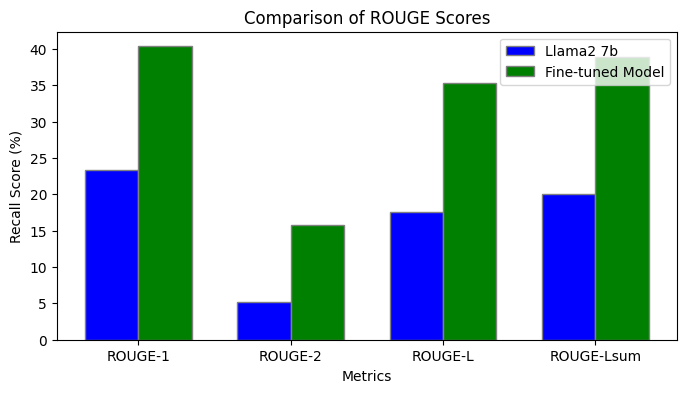

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import numpy as np

rouge_scores_1 = {
    'ROUGE-1': 0.23379845539989186*100,
    'ROUGE-2': 0.05134518409007537*100,
    'ROUGE-L': 0.17608096348754382*100,
    'ROUGE-Lsum': 0.20053441116825088*100
}
rouge_scores_2 = {
    'ROUGE-1': 0.40359236874761295*100,
    'ROUGE-2': 0.15851020592554219*100,
    'ROUGE-L': 0.35390641825963687*100,
    'ROUGE-Lsum': 0.38850303279725756*100
}

labels = list(rouge_scores_1.keys())
values1 = list(rouge_scores_1.values())
values2 = list(rouge_scores_2.values())

bar_width = 0.35

r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(8, 4))
plt.bar(r1, values1, color='blue', width=bar_width, edgecolor='grey', label='Llama2 7b')
plt.bar(r2, values2, color='green', width=bar_width, edgecolor='grey', label='Fine-tuned Model')

plt.xlabel('Metrics')
plt.ylabel('Recall Score (%)')
plt.title('Comparison of ROUGE Scores')
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)

plt.legend()

plt.show()

plt.savefig('rouge_scores.png')

The higher the ROUGE score for all metrics (Rouge1, Rouge2, RougeL, RougeLsum) the better the performance of the model in dialog summarization compared to the reference summaries in the dataset. The evaluation of the fine-tuned model should show higher ROUGE score than the base model when compared to the testing set summaries to prove that the training had an effect.

<h2> BERT Score Evaluation </h2>

In [23]:
!pip install bert-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [45]:
# Function to calculate the average of a list
def calculate_average(values):
    return sum(values) / len(values)

def format_bert(generated, reference):
    generated_newlines = ["\n".join(sent_tokenize(s.strip())) for s in generated]
    reference_newlines = ["\n".join(sent_tokenize(s.strip())) for s in reference]
    
    bert_score = bertscore.compute(
        predictions=generated_newlines, 
        references=reference_newlines, 
        model_type="distilbert-base-uncased"
    )
    average_precision = calculate_average(bert_score['precision'])
    average_recall = calculate_average(bert_score['recall'])
    average_f1 = calculate_average(bert_score['f1'])

    return f"""Average Precision: {average_precision:.4f}, Average Recall: {average_recall:.4f}, Average F1 Score: {average_f1:.4f}"""

In [46]:
format_bert(trained_model_summaries, reference_summaries)

'Average Precision: 0.8352, Average Recall: 0.8323, Average F1 Score: 0.8334'

In [47]:
format_bert(base_model_summaries, reference_summaries)

'Average Precision: 0.7368, Average Recall: 0.7489, Average F1 Score: 0.7403'